### Targeted lipidomics analysis of Pancreas Tissue using LC-MS (Xcalibur) 
#### Comparison is healthy donors, type 1 diabetes donors and type 2 diabetes donors 
###### Details regarding sample groups can be found in README

In [2]:
### Import necessary libraries

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns
import scipy as sp

import sklearn as sk
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA


from scipy.stats import zscore

In [3]:
### Loading lipidomics dataset into pandas df

# Load dataset
lipidomicsDF = pd.read_csv('lipidomicsdatafinal.csv')

# Create a deep copy for analysis
lipidomicsRawAnalysisDf = lipidomicsDF.copy()

# Quick inspection of data types and nulls
lipidomicsRawAnalysisDf.head()

# Make SampleID the index
lipidomicsRawAnalysisDf.set_index('Samples', inplace=True)

# print(lipidomicsRawAnalysisDf.head)
# Statistical summary
# lipidomicsRawAnalysisDf.describe()

In [4]:
# How many zero values are in each column/lipid species

# Count zeros for each column (lipids)
zeroCountsLipids = (lipidomicsRawAnalysisDf == 0.0).sum()

# Count zeros for each row (donors/samples)
zeroCountsDonors = (lipidomicsRawAnalysisDf == 0.0).sum(axis=1)

# Create DataFrame with donor names, zero counts, and percentage
totalLipids = lipidomicsRawAnalysisDf.shape[1]  # Total number of columns (lipids)

zeroCountsDonorsDf = pd.DataFrame({
    'Samples': lipidomicsRawAnalysisDf.index,
    'ZeroCount': zeroCountsDonors.values,
    'ZeroPercentage': (zeroCountsDonors.values / totalLipids) * 100
})

# Similarly for lipids
totalDonors = lipidomicsRawAnalysisDf.shape[0]  # Total number of rows (donors)

zeroCountsLipidsDf = pd.DataFrame({
    'Lipid': zeroCountsLipids.index,
    'ZeroCount': zeroCountsLipids.values,
    'ZeroPercentage': (zeroCountsLipids.values / totalDonors) * 100
})

# Display first 40 entries of each
# zeroCountsLipidsDf.head(40)
zeroCountsDonorsDf.head(40)


,Samples,ZeroCount,ZeroPercentage
0,651_CR,31,10.689655
1,668_C,29,10.000000
2,671_C,26,8.965517
3,674_CR,26,8.965517
4,677_B,25,8.620690
5,679_CR,34,11.724138
6,682_B,27,9.310345
7,685_BR,32,11.034483
8,687_B,29,10.000000
9,690_B,23,7.931034


In [5]:
# Here we are looking for number of "Technical Nulls" (NaNs), not "Numerical Nulls" (Zeros).

# This scans every single cell in your DataFrame. If a cell contains a missing value (like NaN or None), it marks it as True. 
# If it contains a number (even 0), it marks it as False. 
# The first .sum() counts the number of True values in each individual column. 
# The second .sum() adds all those column totals together to give you one single integer representing every missing data point in the entire table

lipidIsNullMissing = lipidomicsRawAnalysisDf.isnull().sum().sum()
if lipidIsNullMissing == 0:
    print("There are no missing values in the dataset.")
else:
    print(f"Total missing values: {lipidIsNullMissing}")

There are no missing values in the dataset.


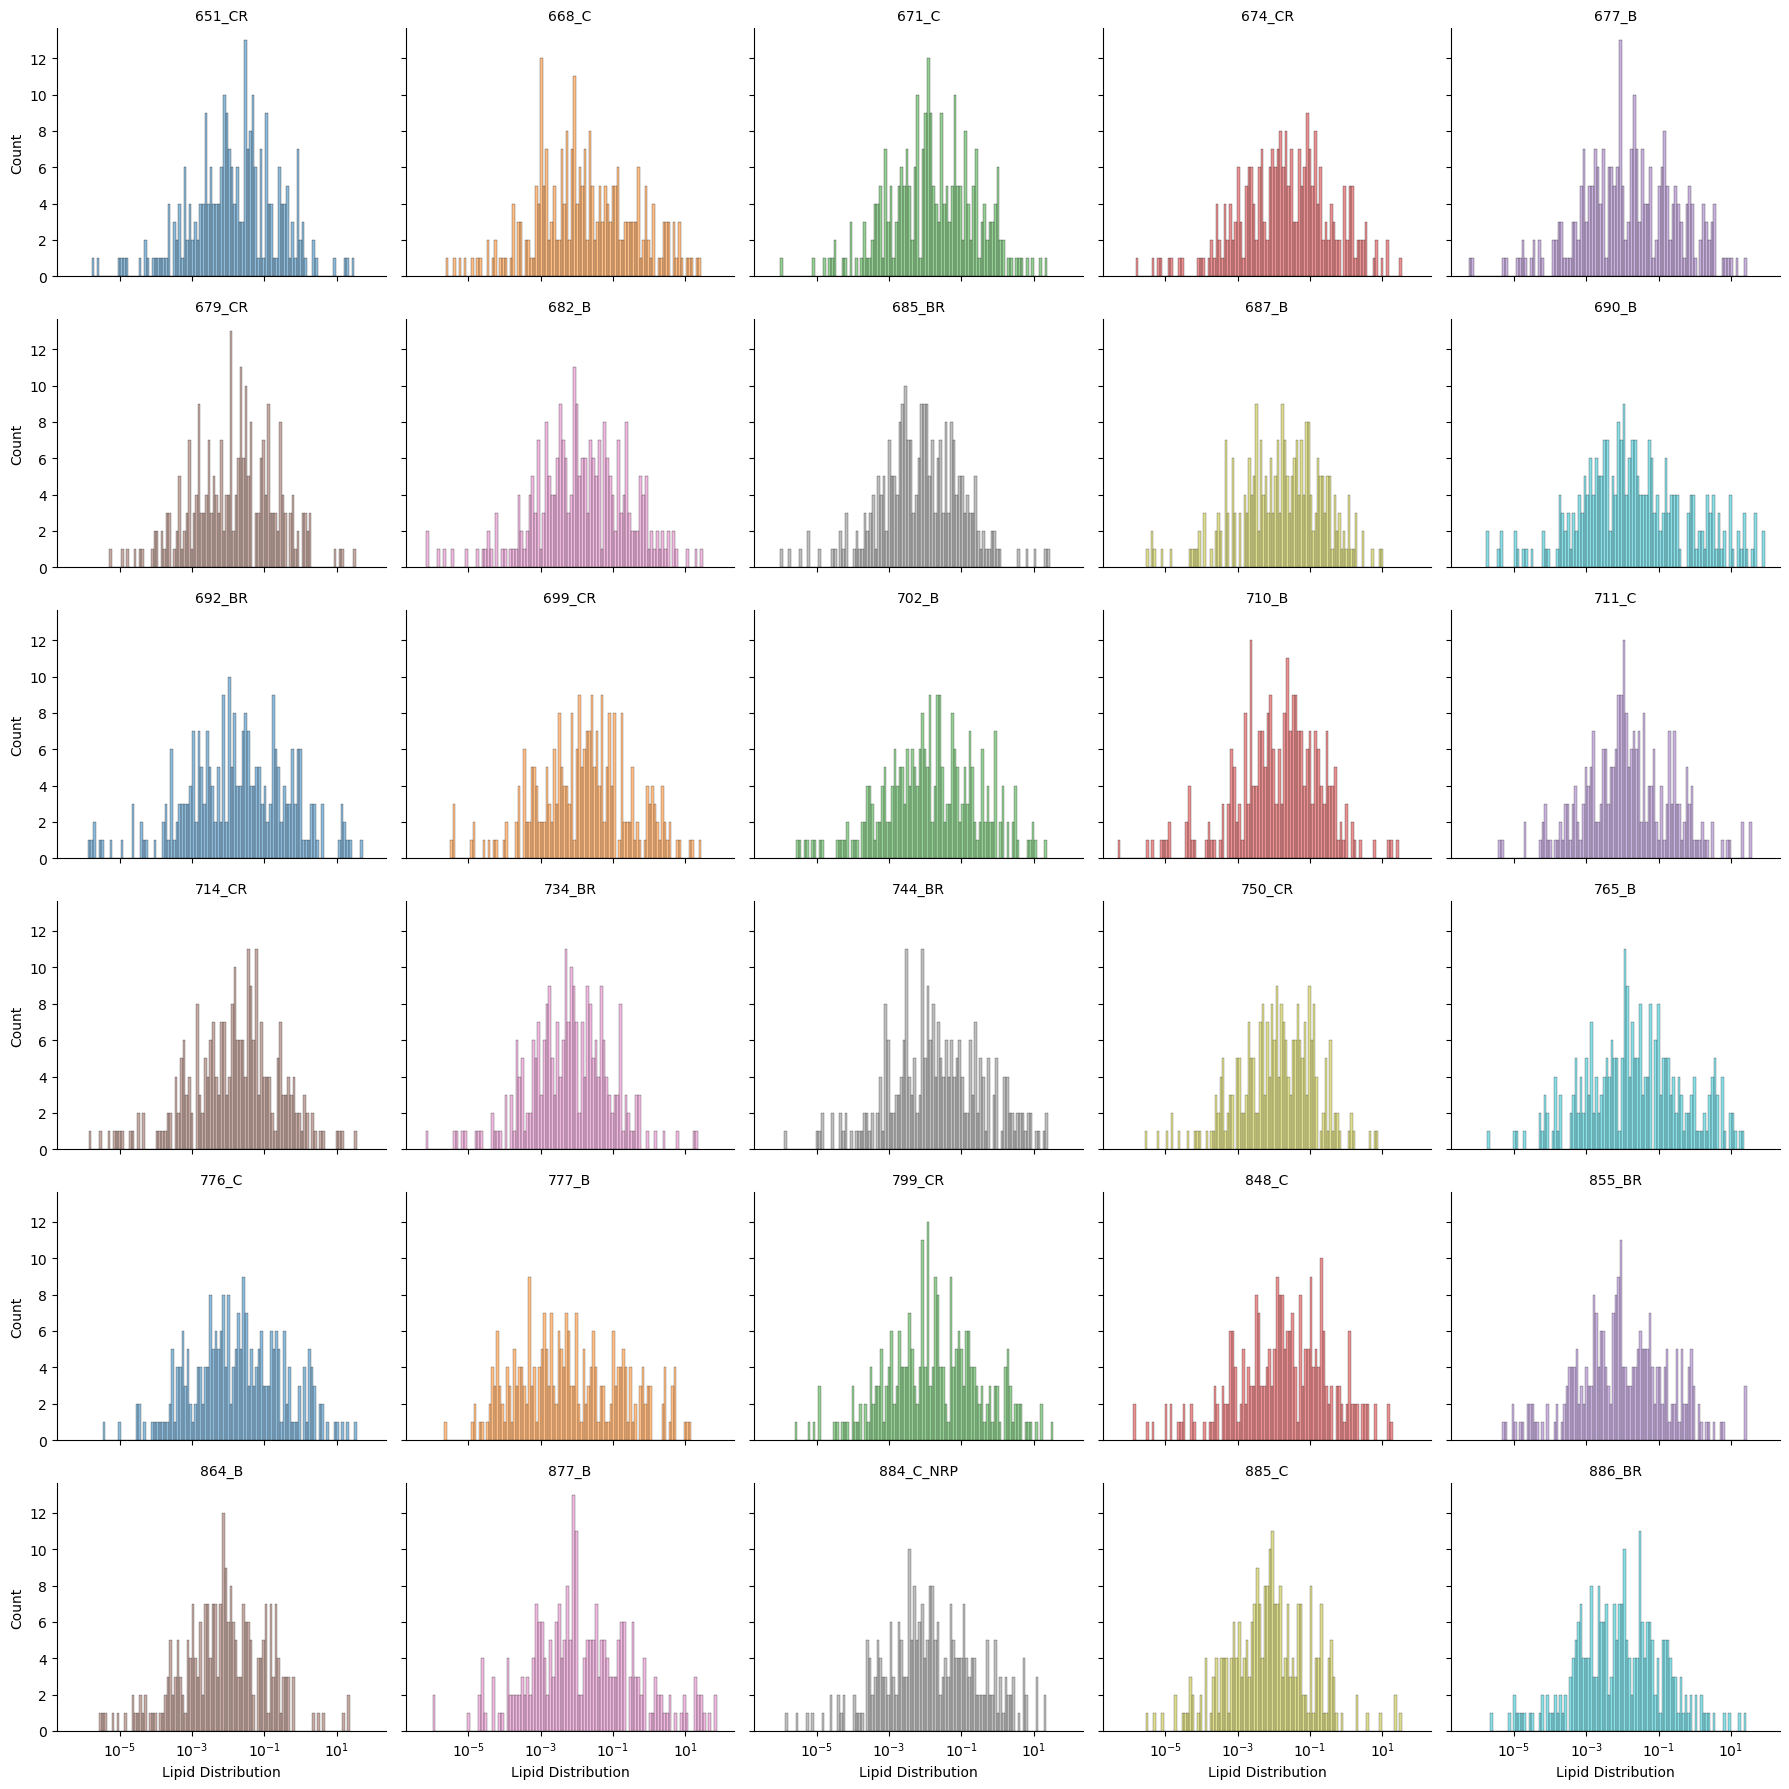

<Figure size 1400x600 with 0 Axes>

In [6]:
# Creating a simple histogram of lipid counts for each donor

# Melt the DataFrame to long format (excluding the 'Group' column)

# Get list of columns excluding 'Group'
dfColsNames = [col for col in lipidomicsRawAnalysisDf.columns if col != 'Group'] 

# Starts transforming the DataFrame from wide format to long format using pandas' melt() function.

# Reset index to convert 'Samples' from index to column
lipidomicsLongRawDf = lipidomicsRawAnalysisDf.reset_index().melt(
    id_vars = ['Samples', 'Group'],
    value_vars = dfColsNames,
    var_name = 'Lipid',
    value_name = 'Distribution'
)

# For simplicity rename T1DM_T2DM to T1DM and change the GESTATIONAL DIABETES to HEALTHY
lipidomicsLongRawDf['Group'] = lipidomicsLongRawDf['Group'].replace({
    'T1DM_T2DM': 'T1DM',
    'GESTATIONAL': 'HEALTHY'
})


# Begin plotting using seaborn's FacetGrid to create histograms for each donor/sample.
facetGridPlot = sns.FacetGrid(
    lipidomicsLongRawDf, 
    col='Samples',
    col_wrap=5, 
    hue='Samples', 
    aspect=1.2, 
    height=3, 
    palette='tab10'
)

facetGridPlot.map(
    sns.histplot, 
    'Distribution', 
    bins=100, 
    kde=True,
    log_scale=True 
)

facetGridPlot.set_titles(col_template="{col_name}")
facetGridPlot.set_xlabels('Lipid Distribution')

plt.figure(figsize=(14, 6))
plt.tight_layout()
plt.show()
plt.close()

In [7]:
# # Conversion of lipid names to RefMet (Reference Metabolome) standard format.

# lipidNamesDF = pd.read_csv('LipidomicsDataforConversion.csv')

# # Put the lipid names into a list for conversion

# lipidNamesOriginalList = lipidNamesDF['Lipid_Names'].tolist()

# # print(lipidNamesOriginalList[:5])

# # Initialise an empty list to store the converted/modified lipid names.

# lipidNamesAlteredList = []

# for lipid in lipidNamesOriginalList:
#      modifiedLipid = lipid.replace('_', ' ', 1)  # The '1' means to replace only the first occurrence with a space
#      modifiedLipid = modifiedLipid.replace('_', ':', 2) # The '2' means to replace the next underscore with a colon
#      if 'Carnitine' in modifiedLipid:
#          modifiedLipid = modifiedLipid.replace('Carnitine', 'CAR')
#      elif 'S ' in modifiedLipid:
#         modifiedLipid = modifiedLipid.replace('S ', 'SHexCer')
#      lipidNamesAlteredList.append(modifiedLipid)

# #print(lipidNamesAlteredList[:20])

# filenameForCorrectLipidList = 'convertedlipidnames.txt'

# # Write the list to a .txt file  

# with open(filenameForCorrectLipidList, 'w') as file:  
#     for lipid in lipidNamesAlteredList:  
#         file.write(lipid + '\n')  # Write each lipid name followed by a newline  

# print(f"Lipid names have been written to {filenameForCorrectLipidList}.") 



This data contains left-censored MNAR data which must be dealt with

Therefore, the modified 80% rule will be used ("variables can be excluded from the data when the proportion of non-missing elements are accounted for less than 80% among each biological group") 

After this, QRILC Imputation will be used in R script called "QRILC_Imputation" using the package imputeLCMD, which has been shown to perform best on left-censored MNAR data 

https://doi.org/10.1038/s41598-017-19120-0


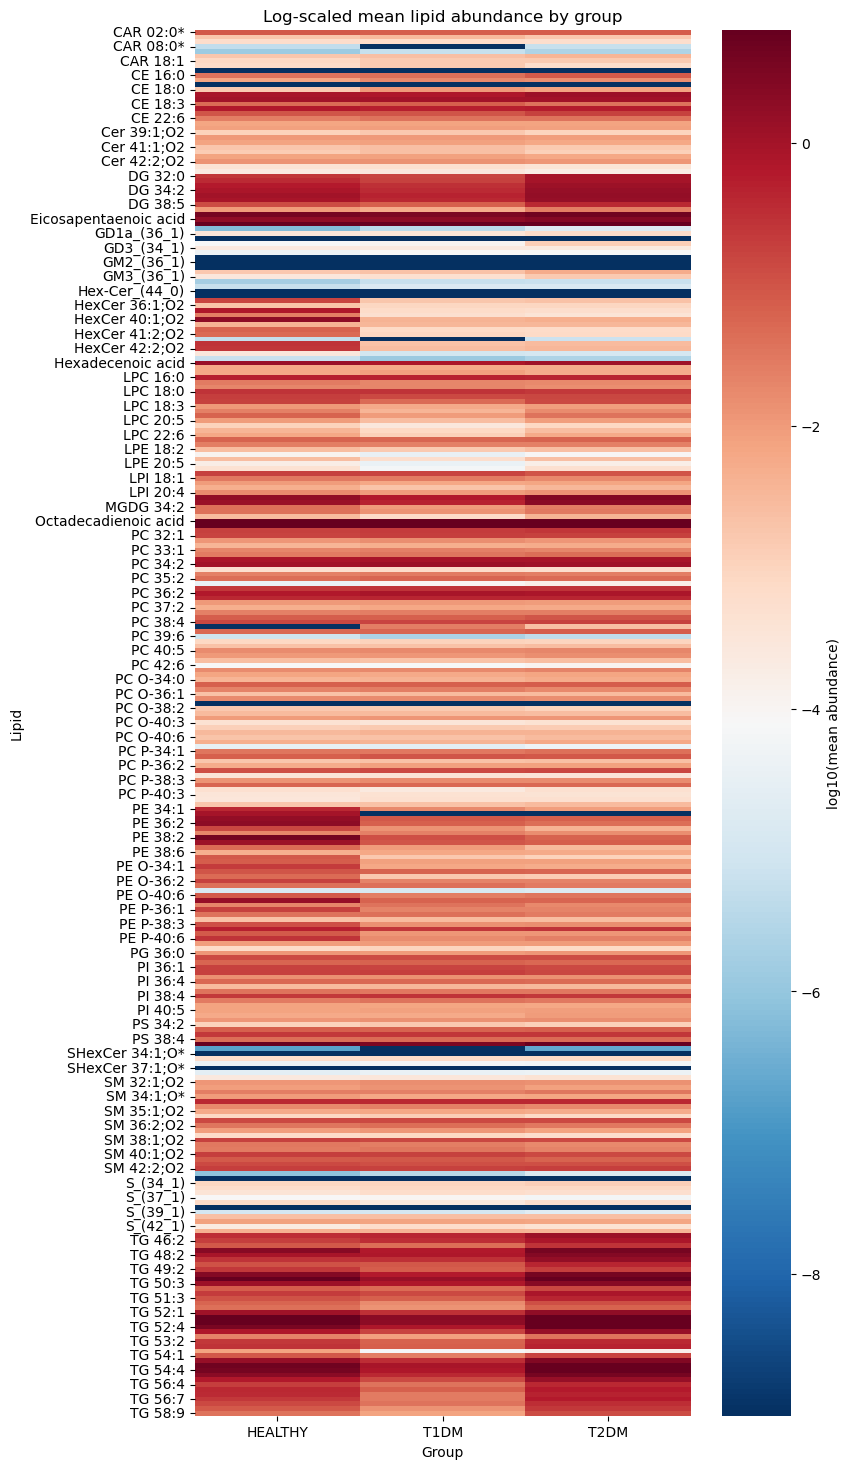

<Figure size 800x1800 with 0 Axes>

In [8]:
# Generate a general heatmap of all lipids across all groups

lipidomicsRawAnalysisDf['Group'] = lipidomicsRawAnalysisDf['Group'].replace({
    'T1DM_T2DM': 'T1DM',
    'GESTATIONAL': 'HEALTHY'
})

heatmapEverythingDf = lipidomicsLongRawDf.pivot_table(
    index='Lipid',
    columns='Group',
    values='Distribution',
    aggfunc='mean'   # explicit, no magic
)

# Use log10 scale for better visualization
pseudoCount = 1e-9
heatmapEverythingLogDf = np.log10(heatmapEverythingDf + pseudoCount)

# plot heatmap
plt.figure(figsize=(8, 18))

sns.heatmap(
    heatmapEverythingLogDf,
    cmap='RdBu_r',
    robust=True,
    cbar_kws={'label': 'log10(mean abundance)'}
)

plt.xlabel('Group')
plt.ylabel('Lipid')
plt.title('Log-scaled mean lipid abundance by group')
plt.figure(figsize=(8, 18))

plt.tight_layout()
plt.show()
plt.close()

In [9]:
# Run the modified 80% rule to filter lipids based on non-zero values within groups

# Step 1: identify feature columns (exclude 'Group')
featureCols = [col for col in lipidomicsRawAnalysisDf.columns if col != 'Group']

# Step 2: create a boolean DataFrame: True if value is non-zero, False if zero
# This is elementwise, creating a DataFrame of booleans (True/False) the same shape as lipidomicsRawAnalysisDf[feature_cols]
nonZeroDf = (lipidomicsRawAnalysisDf[featureCols] != 0)

# Step 3: add the Group column to the boolean DataFrame for grouping
# We need the group information so we can calculate the fraction of non-zero values per group.
nonZeroDf['Group'] = lipidomicsRawAnalysisDf['Group']

# Step 4: compute the fraction of non-zero values per lipid per group
# nonZeroDf.groupby('Group') → splits the DataFrame into sub-DataFrames by unique group.
# .mean() on booleans treats True as 1, False as 0 → calculates fraction of non-zero samples for each lipid in each group.
fractions = nonZeroDf.groupby('Group').mean()

# Step 5: find lipids where the fraction >= 0.8 in any group
keepMask = (fractions >= 0.8).any(axis=0)

# Step 6: apply the mask to keep only the desired lipids + Group column
modified80LipidDf = lipidomicsRawAnalysisDf[['Group'] + keepMask[keepMask].index.tolist()]

print("Original number of lipids:", len(featureCols))
print("Number of lipids after modified 80% rule:", len(modified80LipidDf.columns)-1)


Original number of lipids: 289
Number of lipids after modified 80% rule: 260


In [10]:
# Export the modified DataFrame to a new CSV file for Imputation on R script

modified80LipidDf.index.name = 'Samples'  # Name the index
modified80LipidDf.to_csv('LipidomicsDataModified80PercentRule.csv', index=True)

QRLIC Imputaton completed on R script. Now finishing remaining analysis which includes another heatmap of imputed data and then PCA on the first five components

In [11]:
# Put the imputed csv file output from R into a pandas DataFrame for further analysis

# Load imputed data
imputedLipidDf = pd.read_csv("lipidomics_imputed_data.csv")

# Set Samples as index
imputedLipidDf = imputedLipidDf.set_index("Samples")

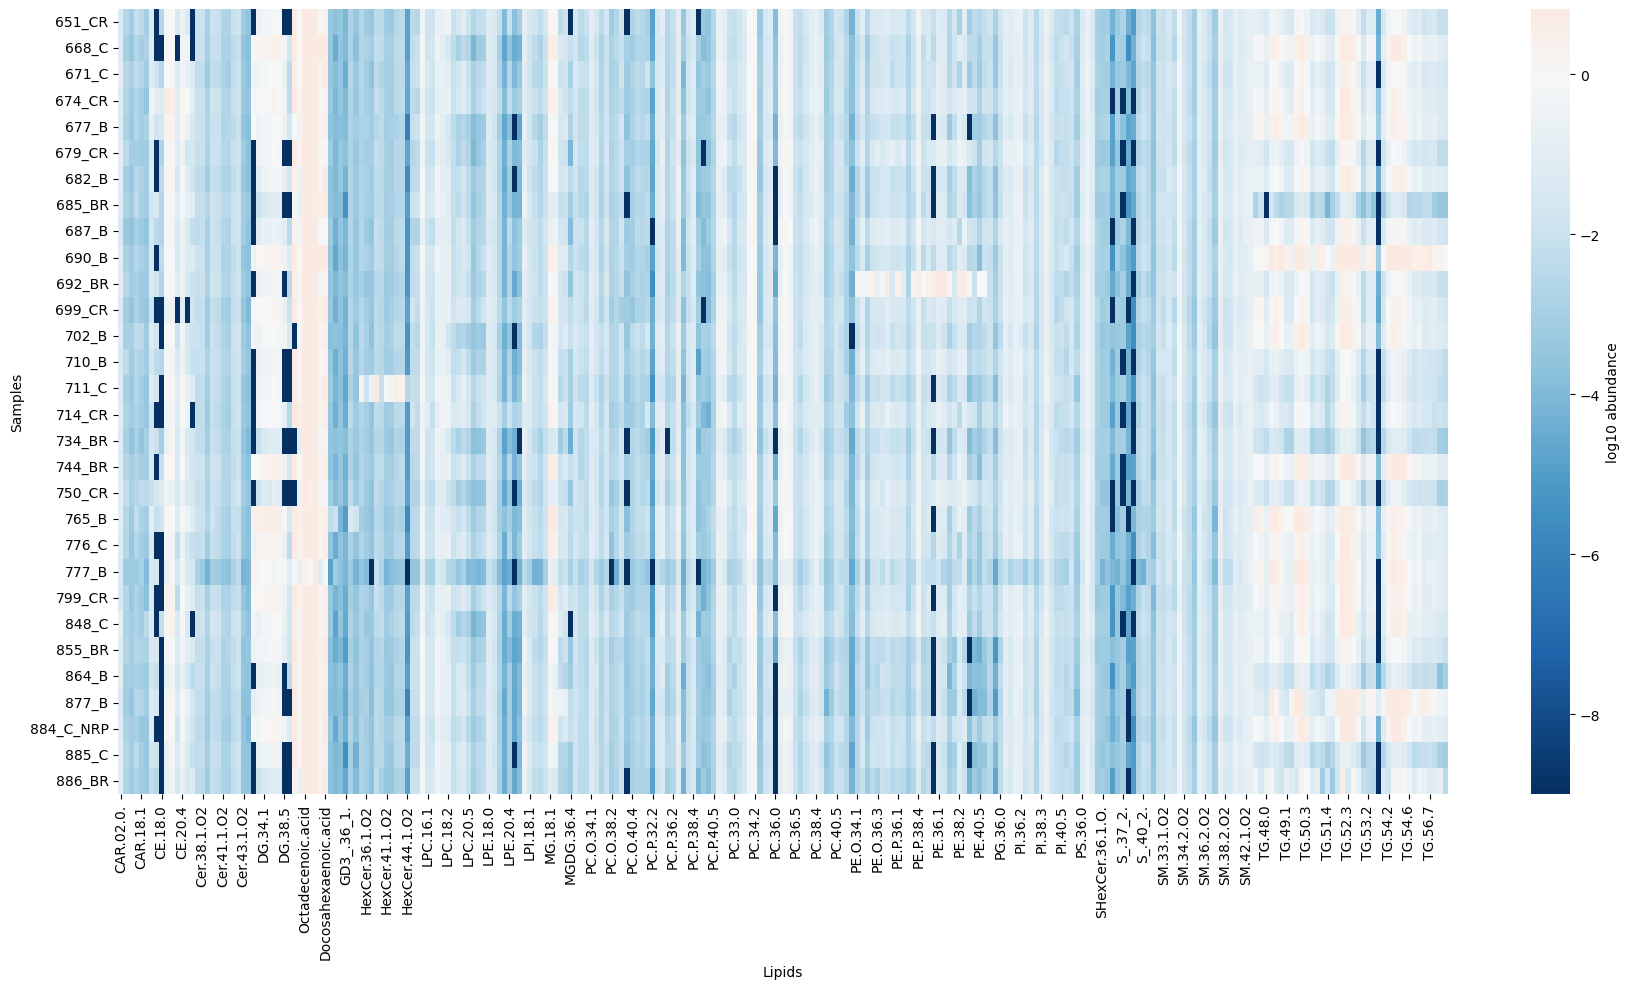

In [12]:
# Heatmap for lipids 

# Separate metadata and lipid matrix
groupLabels = imputedLipidDf["Group"]
lipidMatrix = imputedLipidDf.drop(columns=["Group"])

# Log-transform (recommended for QRILC output)
lipidMatrixLog = np.log10(lipidMatrix + 1e-9)

plt.figure(figsize=(18, 10))
sns.heatmap(
    lipidMatrixLog,
    cmap="RdBu_r",
    center=0,
    robust=True,
    cbar_kws={"label": "log10 abundance"}
)

plt.xlabel("Lipids")
plt.ylabel("Samples")
plt.tight_layout()
plt.show()
plt.close()

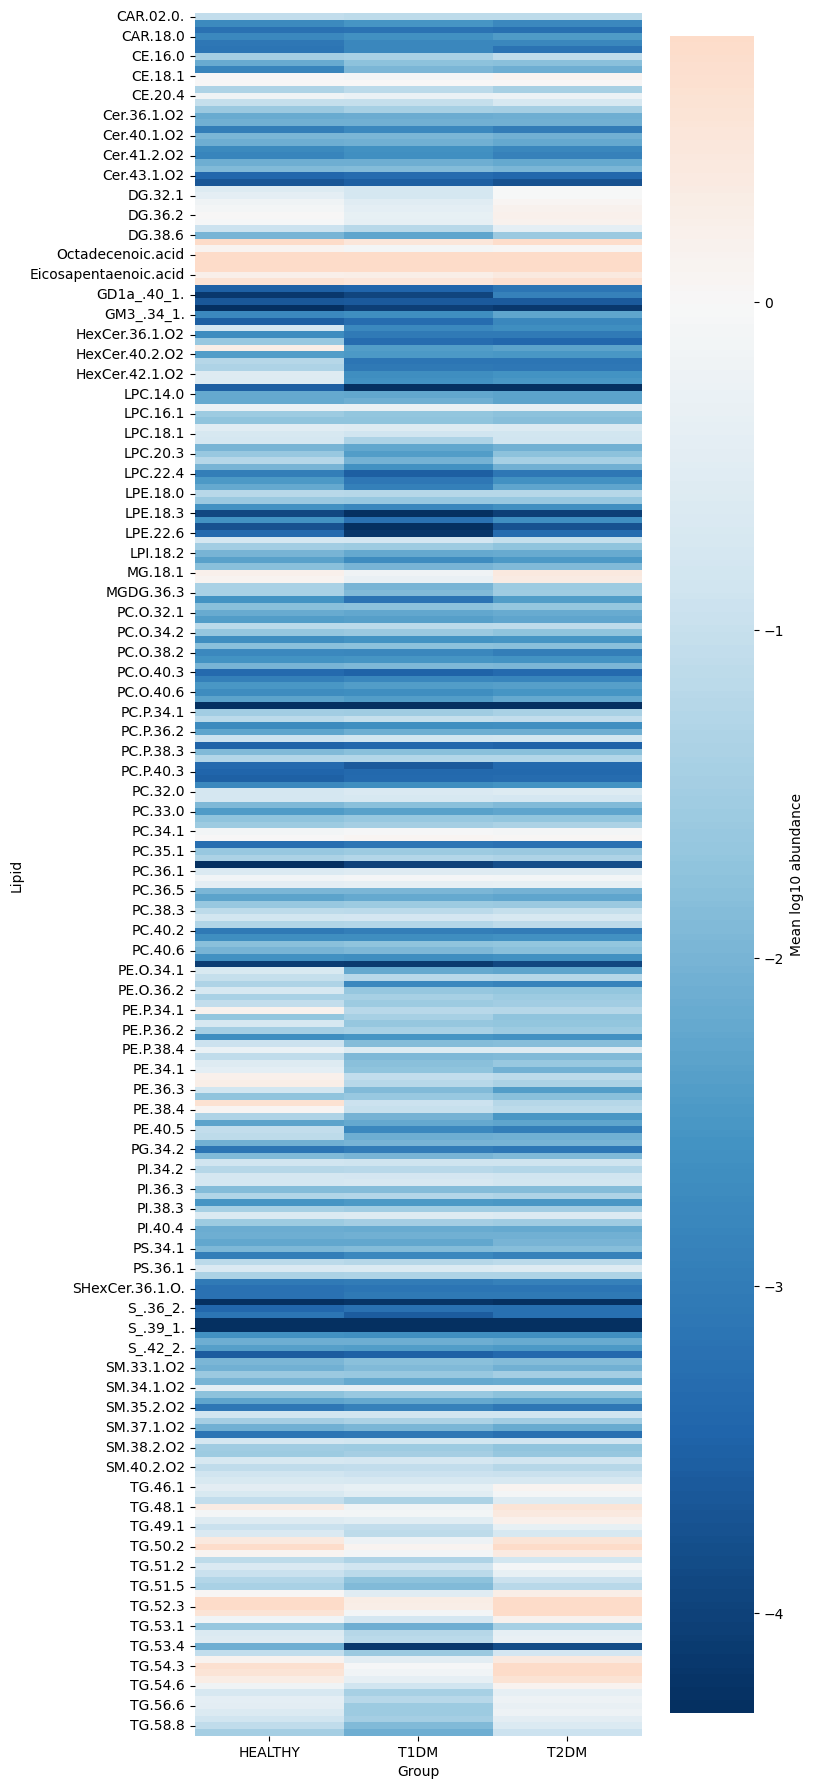

In [13]:
# Combine lipid data with group labels
lipidMatrixWithGroup = lipidMatrix.copy()
lipidMatrixWithGroup["Group"] = groupLabels

# Compute group means
groupMeansDf = lipidMatrixWithGroup.groupby("Group").mean()

# Transpose so lipids are rows
groupMeansTransposedDf = groupMeansDf.T

plt.figure(figsize=(8, 18))
sns.heatmap(
    np.log10(groupMeansTransposedDf + 1e-9),
    cmap="RdBu_r",
    center=0,
    robust=True,
    cbar_kws={"label": "Mean log10 abundance"}
)

plt.xlabel("Group")
plt.ylabel("Lipid")
plt.tight_layout()
plt.show()
plt.close()

Log10 Transformation and Pareto Scaling to be run on the data prior to PCA and PLS-DA visualisation 

This data has already been normalised to wet weight of sample.

Scaling lipid intensities by minumum + maximum values is sensitive to outliers and so scaling by root of SD (Pareto) is better.

After this centering is done by either subtracting the mean/median intensity from all values.

Finally log transformation applied as it has scaling-like effect making features more comparable + it helps reveal multiplicative relations between features.

PMID: 34822371. doi: 10.3390/metabo11110713


In [15]:
# Take the original lipid matrix and apply a log10 transform
# 1e-9 is added so we do not take log(0), which is undefined
lipidMatrixLogDf = np.log10(lipidMatrix + 1e-9)


# Define a tool (called ParetoScaler) that will centre and Pareto-scale the data
# This format allows it to work with scikit-learn tools later
class ParetoScaler(BaseEstimator, TransformerMixin):

    # This function looks at the data and calculates summary values
    # X is the data matrix (rows = samples, columns = lipids)
    def fit(self, X, y=None):

        # Calculate the mean value for each lipid (column-wise)
        self.mean_ = X.mean(axis=0)

        # Calculate the standard deviation for each lipid (column-wise)
        # ddof=1 means we are using the sample standard deviation
        # ddof=1 (Delta Degrees of Freedom):Tells the function to use a divisor of 
        # (N-1) (where (N) is the number of samples) instead of the default (N).
        # This calculates the sample standard deviation (unbiased estimator) rather than the population standard deviation ((ddof=0)
        self.std_  = X.std(axis=0, ddof=1)

        # Replace any zero standard deviations with NaN
        # This prevents division by zero during scaling
        self.std_[self.std_ == 0] = np.nan

        # Return the scaler itself (required by scikit-learn)
        return self


    # This function applies Pareto scaling using the values calculated in fit()
    def transform(self, X):

        # Subtract the mean and divide by the square root of the standard deviation
        # This performs mean-centering and Pareto scaling
        return (X - self.mean_) / np.sqrt(self.std_)


# Create an empty ParetoScaler object
# No calculations happen yet
scaler = ParetoScaler()


# Fit the scaler to the log-transformed data
# This calculates and stores the mean and standard deviation for each lipid
scaler.fit(lipidMatrixLogDf)


# Apply Pareto scaling to the log-transformed data
# This returns a NumPy array with scaled values
lipidMatrixPareto = scaler.transform(lipidMatrixLogDf)


# Convert the scaled NumPy array back into a pandas DataFrame
# This restores the original sample names (rows) and lipid names (columns)
lipidMatrixParetoCentreDf = pd.DataFrame(
    lipidMatrixPareto,
    index=lipidMatrixLogDf.index,
    columns=lipidMatrixLogDf.columns
)




In [ ]:
# Check the df 
# Line 1: calculates the mean of each lipid (column-wise), 
# takes absolute value (just to ignore negative signs) and finds the largest mean among all lipids
# Line 2: This tells you if any columns became unusable after scaling (i.e., all NaNs)
lipidMatrixPareto.mean(axis=0).abs().max()   # should be ~0
lipidMatrixPareto.isna().sum().sum()         # check dropped lipids

np.int64(0)

In [26]:
# Add Group column directly from original DF using index, no duplicate column
lipidMatrixParetoCentreDf['Group'] = imputedLipidDf.loc[lipidMatrixParetoCentreDf.index, 'Group']

# Move Group to the front (second column after index)
colsLipidCorrectOrder = ['Group'] + [c for c in lipidMatrixParetoCentreDf.columns if c != 'Group']
lipidMatrixParetoCentreDf = lipidMatrixParetoCentreDf[colsLipidCorrectOrder]

# Check result
lipidMatrixParetoCentreDf.head()


,Group,CAR.02.0.,CAR.03.0.,CAR.05.0.,CAR.18.0,CAR.18.1,CAR.18.2,CE.16.0,CE.16.1,CE.18.0,...,TG.54.4,TG.54.5,TG.54.6,TG.56.4,TG.56.5,TG.56.6,TG.56.7,TG.56.8,TG.58.8,TG.58.9
Samples,,,,,,,,,,,,,,,,,,,,,
651_CR,T2DM,-0.404766,0.289116,0.244961,1.129237,1.009846,0.245317,0.069708,-2.269463,1.517670,...,-0.280152,-0.279883,-0.317878,-0.215975,-0.250162,-0.710874,-0.373920,-0.225408,-0.533446,-0.273550
668_C,T2DM,-0.240352,-0.463908,-0.556548,0.149224,-0.175903,0.687820,0.696503,-2.269463,-1.930006,...,0.792486,0.719916,0.671682,0.803638,0.723151,0.529607,0.619835,0.732768,0.667172,0.772671
671_C,T2DM,0.697133,0.512058,0.776934,0.776892,0.753059,0.172958,0.275284,1.544757,1.514844,...,-0.089896,-0.063313,-0.040273,0.080513,0.157521,-0.342904,-0.095936,0.020258,0.123446,0.169197
674_CR,T2DM,-0.071656,0.202335,-0.150441,-0.016681,-0.085615,-0.649448,1.610831,1.974568,2.269564,...,0.300277,0.276761,0.301843,0.382093,0.344837,0.224045,0.181527,0.065163,0.363972,0.421924
677_B,T1DM,-0.186188,-0.244742,-0.223292,0.034551,-0.090804,0.551030,0.987729,1.503010,2.066842,...,0.374384,0.425990,0.501004,0.401466,0.422260,0.323418,0.216219,0.438302,0.338013,0.410921


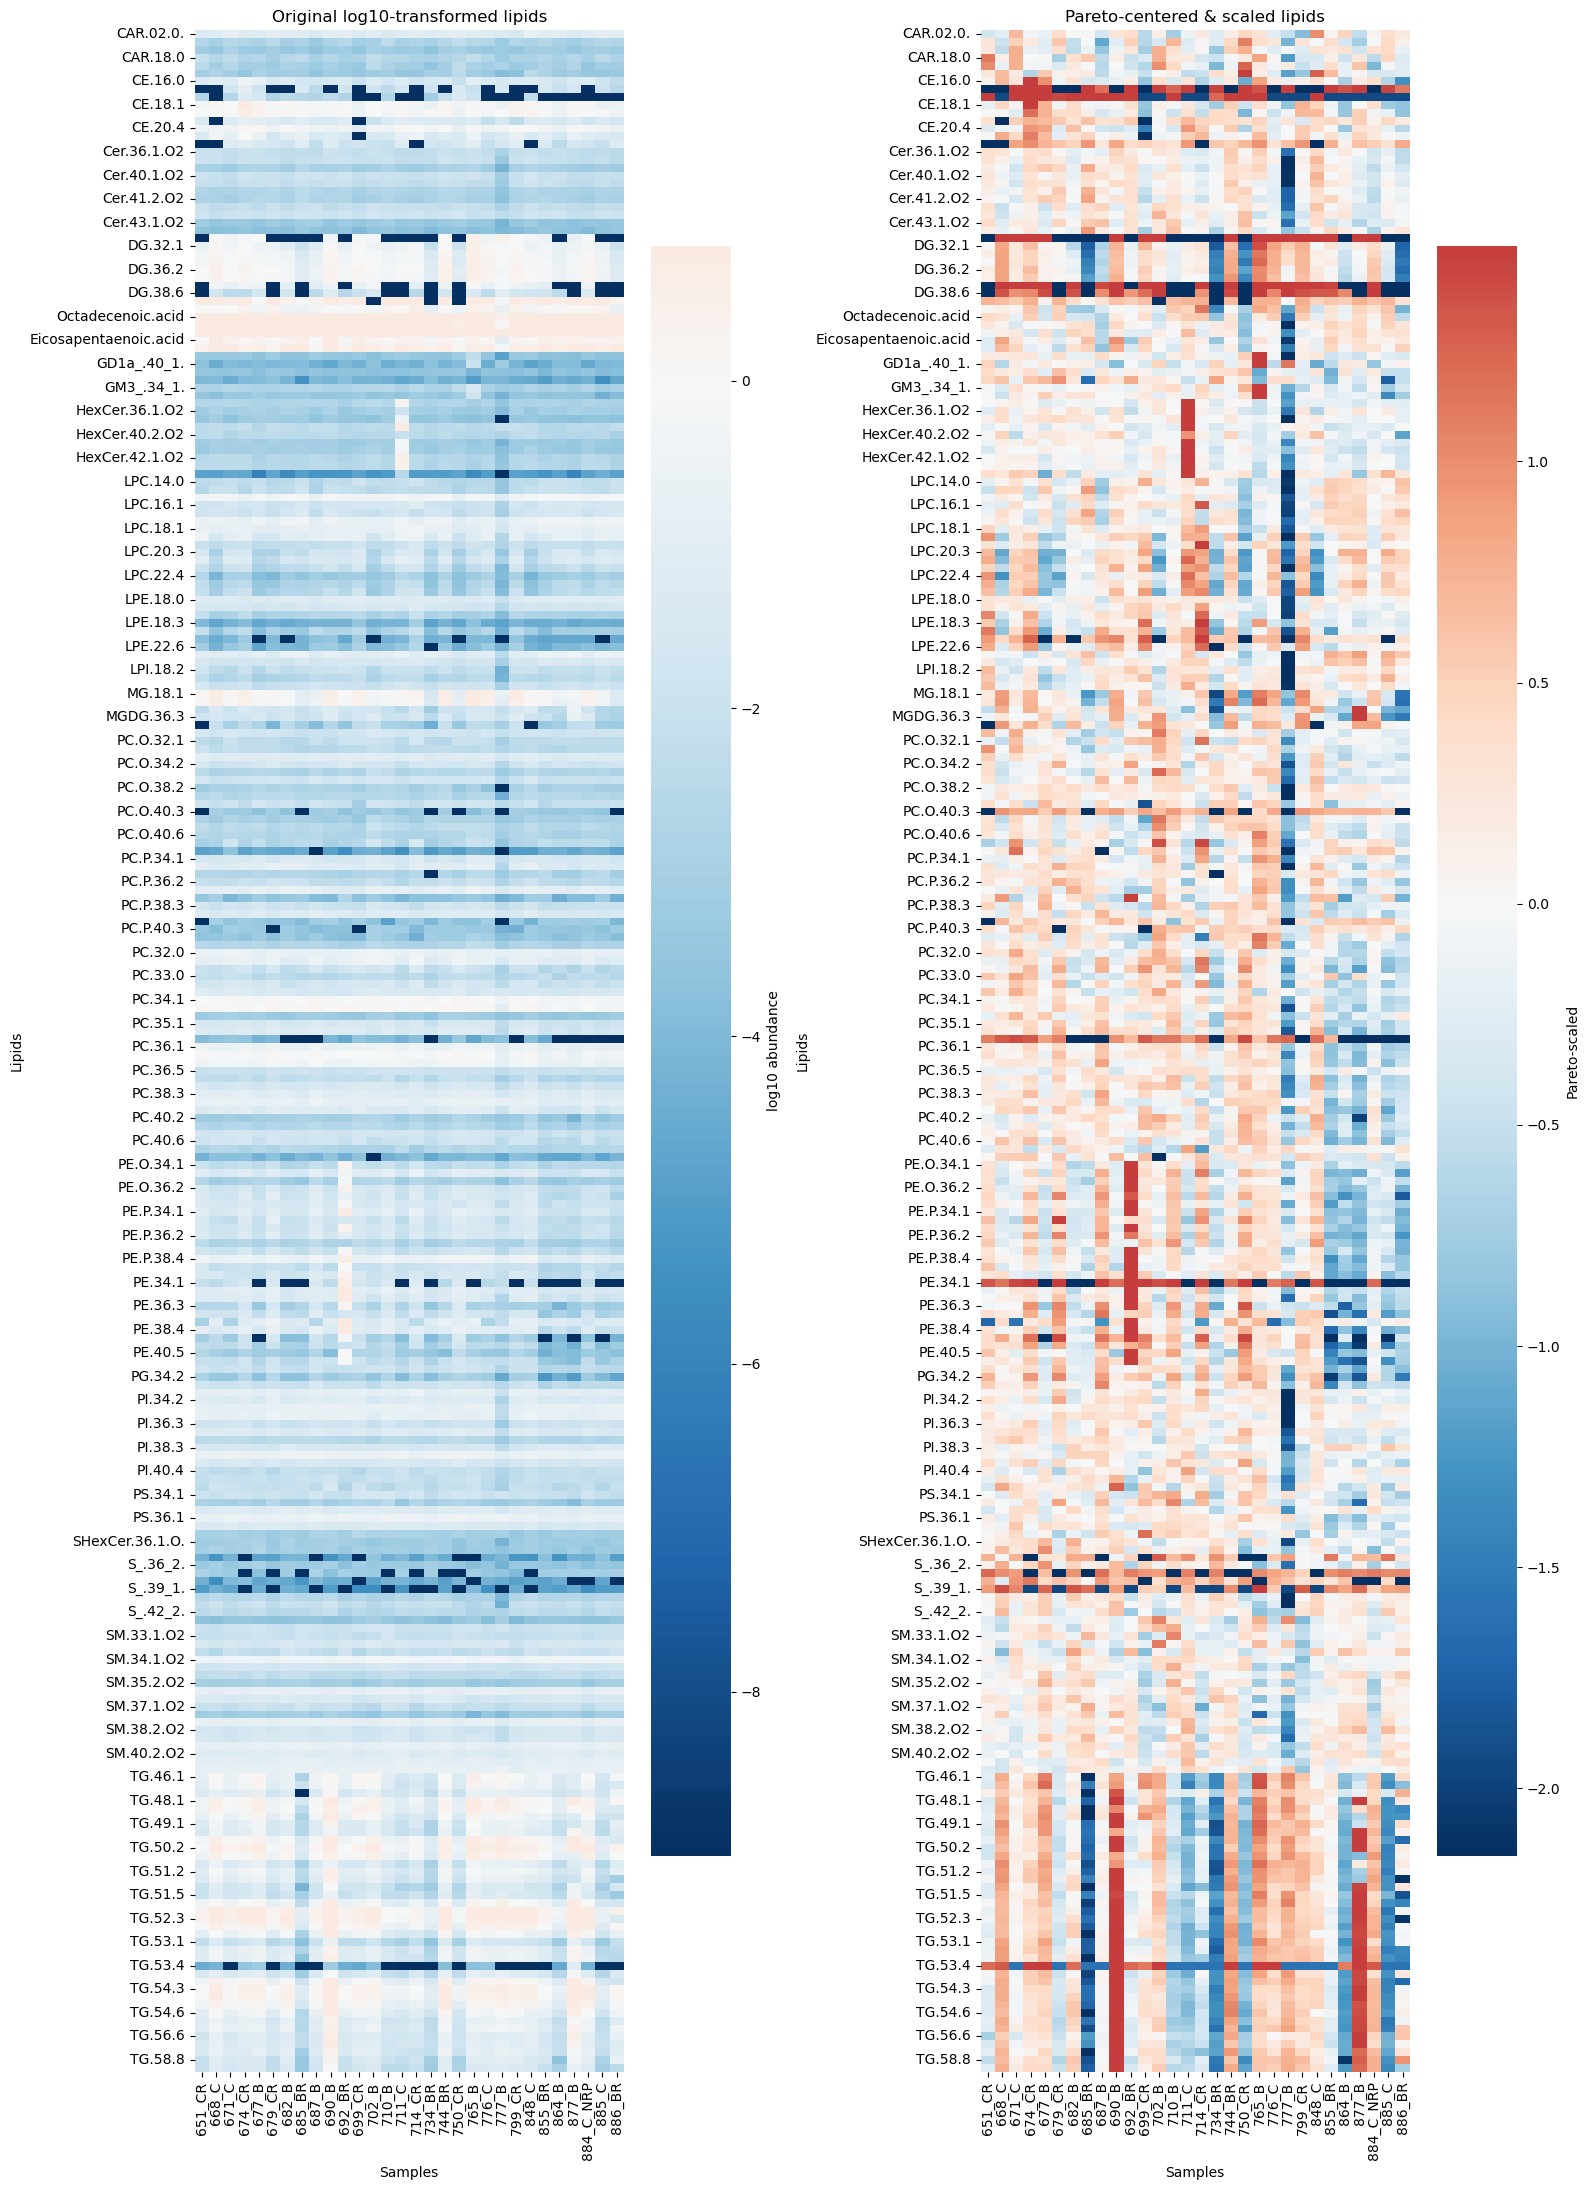

In [34]:
# Heatmap of lipids before and after Pareto scaling (transposed)

# lipidMatrixParetoCentreDf should have lipids columns only (index = samples)
lipidMatrixParetoOnly = lipidMatrixParetoCentreDf.drop(columns=['Group'], errors='ignore')

# Transpose so lipids are rows, samples are columns
lipidMatrixLogT = lipidMatrixLog.T
lipidMatrixParetoT = lipidMatrixParetoOnly.T

# Set figure with 2 heatmaps side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 22))

# Left: Original log10-transformed data
sns.heatmap(
    lipidMatrixLogT,
    ax=axes[0],
    cmap="RdBu_r",
    center=0,
    robust=True,
    cbar_kws={"label": "log10 abundance"}
)
axes[0].set_title("Original log10-transformed lipids")
axes[0].set_xlabel("Samples")
axes[0].set_ylabel("Lipids")

# Right: Pareto-centered & scaled data
sns.heatmap(
    lipidMatrixParetoT,
    ax=axes[1],
    cmap="RdBu_r",
    center=0,
    robust=True,
    cbar_kws={"label": "Pareto-scaled"}
)
axes[1].set_title("Pareto-centered & scaled lipids")
axes[1].set_xlabel("Samples")
axes[1].set_ylabel("Lipids")

plt.tight_layout()
plt.show()
plt.close()


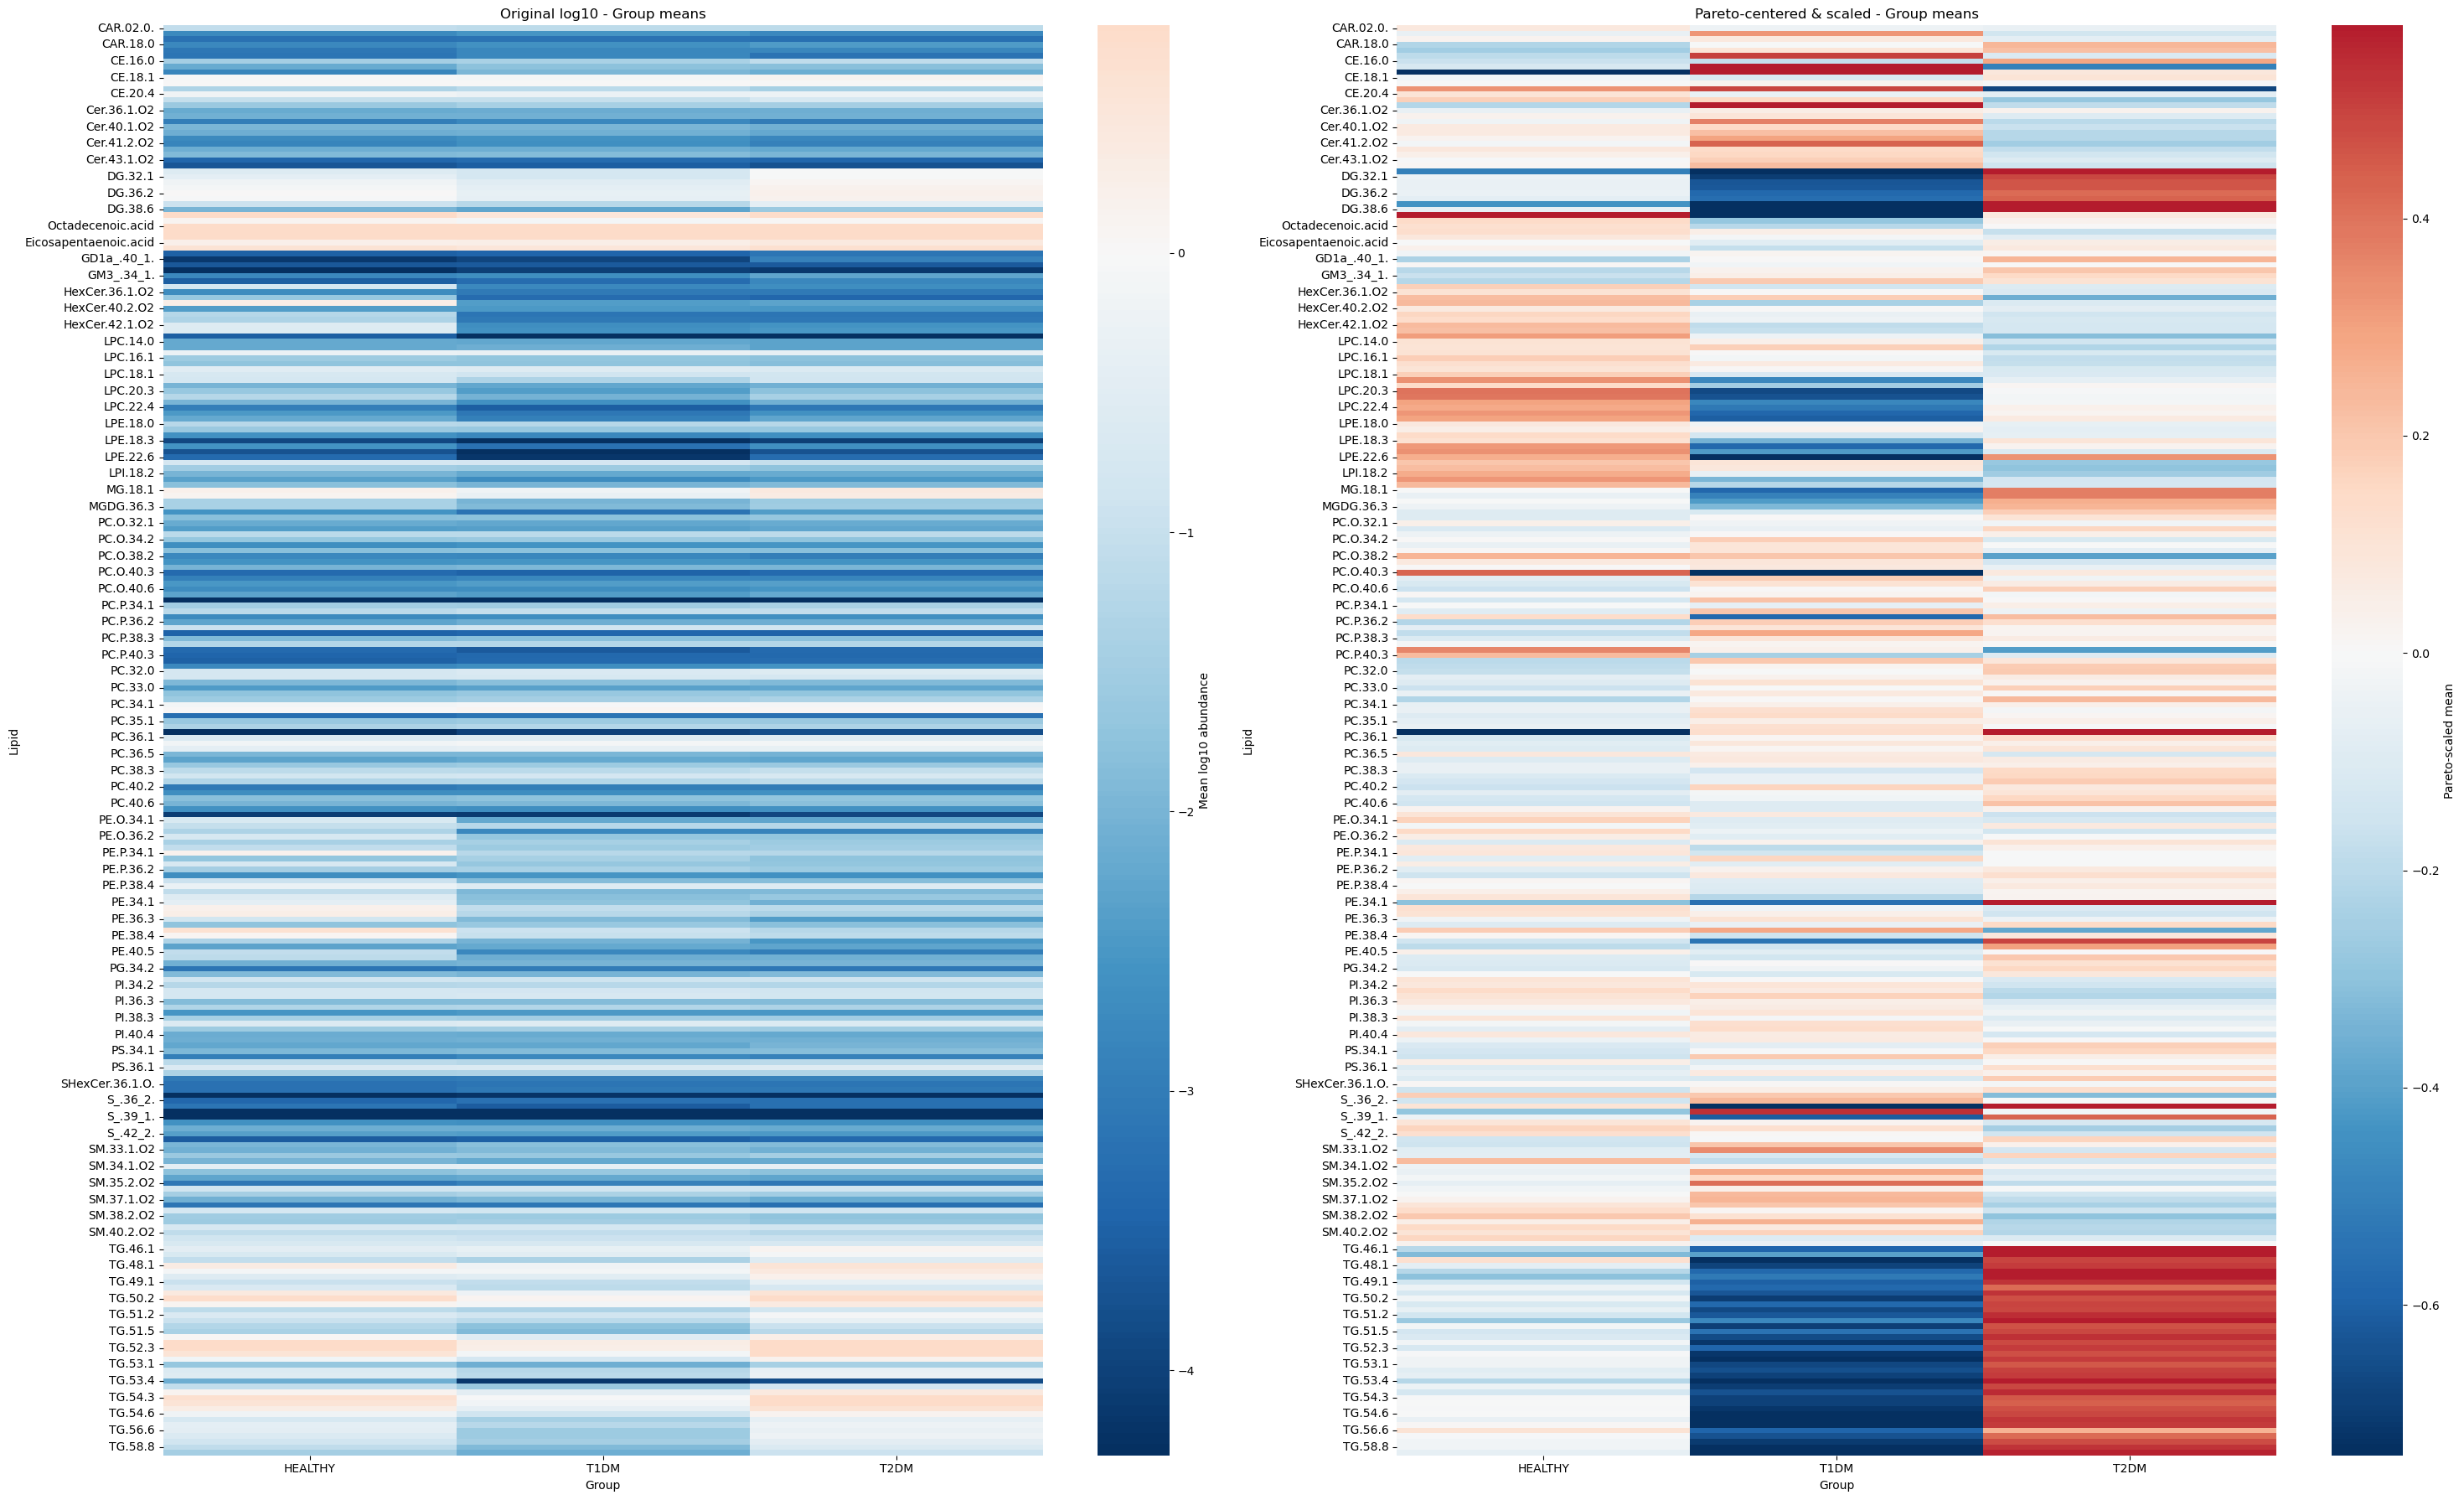

In [32]:
# Combine Pareto-scaled lipid data with group labels
lipidMatrixParetoWithGroup = lipidMatrixParetoCentreDf.copy()
lipidMatrixParetoWithGroup["Group"] = groupLabels  # use the same groupLabels variable

# Compute group means for Pareto-scaled data
groupMeansParetoDf = lipidMatrixParetoWithGroup.groupby("Group").mean()

# Transpose so lipids are rows
groupMeansParetoTransposedDf = groupMeansParetoDf.T

# Set figure with 2 heatmaps side by side
fig, axes = plt.subplots(1, 2, figsize=(30, 18))  # taller figure for many lipids

# Left: Original log10-transformed group means (already computed)
sns.heatmap(
    np.log10(groupMeansTransposedDf + 1e-9),
    ax=axes[0],
    cmap="RdBu_r",
    center=0,
    robust=True,
    cbar_kws={"label": "Mean log10 abundance"}
)
axes[0].set_title("Original log10 - Group means")
axes[0].set_xlabel("Group")
axes[0].set_ylabel("Lipid")

# Right: Pareto-scaled group means
sns.heatmap(
    groupMeansParetoTransposedDf,
    ax=axes[1],
    cmap="RdBu_r",
    center=0,
    robust=True,
    cbar_kws={"label": "Pareto-scaled mean"}
)
axes[1].set_title("Pareto-centered & scaled - Group means")
axes[1].set_xlabel("Group")
axes[1].set_ylabel("Lipid")

plt.tight_layout()
plt.show()
plt.close()

In [35]:
# Generate PCA plots for Pareto-scaled data and original log-transformed data

pca_pareto = PCA(n_components=5)
principalComponentsPareto = pca_pareto.fit_transform(lipidMatrixParetoOnly)

# Put into df
principalComponentsParetoDf = pd.DataFrame(
    data = principalComponentsPareto,
    columns= ['PC1', 'PC2', 'PC3', 'PC4', 'PC5']
)

principalComponentsParetoDf.head()

,PC1,PC2,PC3,PC4,PC5
0,-2.435989,3.964453,-0.451446,-1.647070,-0.814314
1,7.283060,-0.190833,1.489242,-1.252563,2.857746
2,1.663518,1.060707,0.569463,0.944579,1.868856
3,4.302858,4.993517,-0.102965,1.465983,-0.963006
4,4.088022,-3.608679,1.246438,6.785252,0.191446
